Tutorial 1: Non-linear Search
=============================

In this example, we're going to find a lens model that provides a good fit to an image, without assuming any knowledge
of what the 'correct' lens model is.

So, whats a 'lens model'? It is the combination of _LightProfile_'s and _MassProfile_'s we use to represent a lens galaxy,
source galaxy and therefore the strong lens ray-tracing configuration (i.e. the _Tracer_).

To begin, we have to choose the parametrization of our lens model. We don't need to specify the values of its light
and mass profiles (e.g. the centre, einstein_radius, etc.) - only the profiles themselves. In this example,
we'll use the following lens model:

1) A _SphericalIsothermal_ Sphere (SIS) for the lens galaxy's mass.
2) A _SphericalExponential_ _LightProfile_ for the source-galaxy's light.

I'll let you into a secret - this is the same lens model used to simulate the _Imaging_ data we're going to fit and
we're going to infer the actual parameters I used!

So, how do we infer the light and mass profile parameters that give a good fit to our data?

Well, we could randomly guess a lens model, corresponding to some random set of parameters. We could use this
lens model to create a _Tracer_ and fit the _Imaging_ with it, via a _FitImaging_ object. We can quantify how good the
fit is using its log likelihood (recall chapter_1/tutorial_8). If we kept guessing lens models, eventually we'd find
one that provides a good fit (i.e. high log_likelihood) to the data!

It may sound surprising, but this is actually the basis of how lens modeling works. However, we can do a lot better
than random guessing. Instead, we track the log likelihood of our previous guesses and guess more models using
combinations of parameters that gave higher log_likelihood solutions previously. The idea is that if a set of parameters
provided a good fit to the data, another set with similar values probably will too.

This is called a 'non-linear search' and its a fairly common problem faced by scientists. Over the next few tutorials,
we're going to really get our heads around the concept of a non-linear search - intuition which will prove crucial to
being a successful lens modeler.

We're going to use a non-linear search algorithm called 'Dynesty'. I highly recommend it, and find its great for
lens modeling. However, for now, lets not worry about the details of how Dynesty actually works. Instead, just
picture that a non-linear search in PyAutoLens operates as follows:

1) Randomly guess a lens model and use its _LightProfile_'s and _MassProfile_'s to set up a lens galaxy, source galaxy
and a _Tracer_.

2) Use this _Tracer_ and a _MaskedImaging_ to generate a model image and compare this model image to the
observed strong lens _Imaging_ data using a _FitImaging_ object, providing the log likelihood.

3) Repeat this many times, using the likelihoods of previous fits (typically those with a high log_likelihood) to
guide us to the lens models with the highest log likelihood.

In [1]:
%matplotlib inline

from autoconf import conf
import autofit as af  # <- This library is used for non-linear fitting.
import autolens as al
import autolens.plot as aplt

You're going to see a line like the one below (with 'conf.instance =') in every tutorial this chapter. This sets the
following two properties:

 - The path to the configuration files used by PyAutoLens, some of which configure the non-linear search. You need 
   to give the path to your autolens_workspace, so the configuration files in the workspace are used (e.g. 
   '/path/to/autolens_workspace/config'). 

 - The path to the PyAutoLens output folder, which is where the results of the non-linear search are written to 
   on your hard-disk, alongside visualization and other properties of the fit 
   (e.g. '/path/to/autolens_workspace/output/howtolens')

(These will work autommatically if the WORKSPACE environment variable was set up correctly during installation. 
Nevertheless, setting the paths explicitly within the code is good practise.

Setup the path to the autolens workspace, using the project pyprojroot which determines it automatically.

In [2]:
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

conf.instance = conf.Config(
    config_path=f"{workspace_path}/howtolens/config",
    output_path=f"{workspace_path}/howtolens/output",
)

Workspace Path:  /home/carlos/autolens_workspace


Lets loads the _Imaging_ dataset we'll fit a lens model with using a non-linear search. If you are interested in how
we simulate strong lens data, checkout the scripts in the folder 'autolens_workspace/howtolens/simulators'.

The strong lens in this image was generated using:

 - The lens galaxy's _MassProfile_ is a *SphericalIsothermal*.
 - The source galaxy's _LightProfile_ is a *SphericalExponential*.

Below, you'll notice the command:

    'from autolens_workspace.howtolens.simulators.chapter_2 import lens_sis__source_exp'
    
This will crop up in nearly every tutorial from here on. This imports the simulator for the dataset we fit in the 
tutorial, simulating the data and placing it in the folder:

    'autolens_workspace/howtolens/dataset/chapter_2/lens_sis__source_exp'    
    
To see how the _Imaging_ dataset is simulated, feel free to checkout the simulators in the folder:

    'autolens_workspace/howtolens/simmulators'

In [5]:
from howtolens.simulators.chapter_2 import lens_sis__source_exp

dataset_type = "chapter_2"
dataset_name = "lens_sis__source_exp"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)


The non-linear fit also needs a _Mask_, lets use a 3.0" circle.

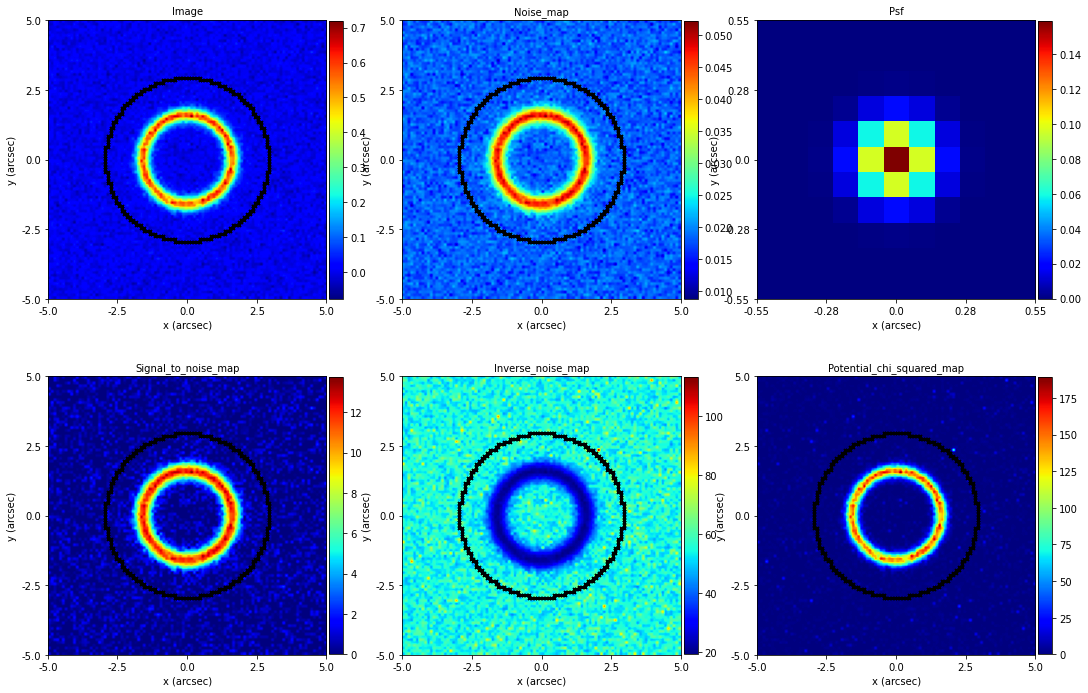

In [6]:
mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, radius=3.0
)

aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

To compute a lens model, we use a _GalaxyModel_, which behaves analogously to the _Galaxy_ objects we're now used to. 
However, whereas for a _Galaxy_ we manually specified the value of every parameter of its _LightProfile_'s and 
_MassProfile_'s, for a _GalaxyModel_ these are fitted for and inferred by the non-linear search.

Lets model the lens galaxy with an _SphericalIsothermal_ _MassProfile_ (which is what it was simulated with).

In [7]:
lens_galaxy_model = al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalIsothermal)

Lets model the source galaxy with a spherical exponential _LightProfile_ (again, what it was simulated with).

In [8]:
source_galaxy_model = al.GalaxyModel(redshift=1.0, light=al.lp.SphericalExponential)

We can use a _PhaseSettingsImaging_ object to customize how a _Tracer_ and _FitImaging_ are used to fit the _Imaging_ 
dataset. Below, we specify:

 - That a regular *Grid* is used to fit create the model-image when fitting the data 
      (see 'autolens_workspace/examples/grids.py' for a description of grids).
 - The sub-grid size of this grid.

You'll note that the output folder of non-linear seach results has been 'tagged' with these phase settings. We'll 
discuss this and phase settings in more detail in a later tutorial.

In [9]:
settings = al.PhaseSettingsImaging(grid_class=al.Grid, sub_size=2)

To fit the galaxy models above via a non-linear search (in this case, Dynesty) we use a _PhaseImaging_ object. Phases
bring together the model, non-linear search and data, in order to perform a model-fit and thus infer a lens model.

(Just like we could give profiles descriptive names, like 'light', 'bulge' and 'disk', we can do the exact same 
thing with the phase's galaxies. This is good practise - as once we start using complex lens models, you could 
potentially have a lot of galaxies - and this is the best way to keep track of them!).

You'll note that we also pass the non-linear 'search' _DynestyStatic_ to this phase, specifying some input parameters
(n_live_points). We'll cover what these do in a later tutorial. You'll also note that the output path of the results 
are 'tagged' with some of these settings.

In [10]:
phase = al.PhaseImaging(
    phase_name="phase_t1_non_linear_search",
    settings=settings,
    galaxies=dict(lens_galaxy=lens_galaxy_model, source_galaxy=source_galaxy_model),
    search=af.DynestyStatic(n_live_points=40),
)

To run the phase, we pass it the data we're going to fit a lens model to and the non-linear search begins!

Model fits using a non-linear search can take a long time to run. Whilst the fit in this tutorial should take of order 
~10 minutes, later tutorials will take upwards of hours! This is fine, afterall lens modeling is an inherently 
computationally expensive exercise, but does make going through these tutorials problematic.

Furthermore, in a Jupyter notebook, if you run the non-linear search (using the phase.run command below) you won't 
be able to continue the notebook until it has finished. For this reason, we recommend that you run the non-linear
search in these tutorials not via your Juypter notebook, but instead by running the tutorial script found in the
'chapter_2_lens_modeling/scripts' folder. This can be run either using the 'python3 tutoial_1_non_linear_search.py' 
command on your command line or via your IDE (if you are using one).

The non-linear search outputs all results to your hard-disk, thus if it runs and finishes in the script, you can then
run the Jupyter notebook cell and immediately load the results. This is how we recommend all non-linear searches are 
performed in PyAutoLens and is therefore a good habit to get into. In these tutorials, we have commented the 
'phase.run' command below in every cell to remind you that you should go to the tutorial script in the 
'chapter_2_lens_modeling/scripts' folder, uncomment the line and run the entire script!

In [11]:
print(
    "Dynesty has begun running - checkout the autolens_workspace/output/"
    "folder for live output of the results, images and lens model."
    "This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

#results = phase.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the autolens_workspace/output/folder for live output of the results, images and lens model.This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
143it [00:20,  8.31it/s, bound: 3 | nc: 7 | ncall: 1373 | eff(%): 10.415 | loglstar:   -inf < -19336.240 <    inf | logz: -19344.153 +/-    nan | dlogz: 2383.646 >  0.049] /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
155it [00:22,  9.52it/s, bound: 6 | nc: 5 | ncall: 1463 | eff(%): 10.595 | loglstar:   -inf < -19214.789 <    inf | logz: -19222.998 +/-    nan | dlogz: 2251.973 >  0.049] /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation 

Dynesty has finished run - you may now continue the notebook.


Now this is running you should checkout the 'autolens_workspace/output' folder.

This is where the results of the phase are written to your hard-disk (in the '1_non_linear_search' folder). When its 
completed, images and output will also appear in this folder, meaning that you don't need to keep running Python 
code to see the results.

In fact, even when a phase is running, it outputs the the current maximum log likelihood results of the lens model 
to your hard-disk, on-the-fly. If you navigate to the output/howtolens folder, even before the phase has finished, 
you'll see:

    1) The 'image' folder, where the current maximum log likelihood lens model _Tracer_ and _FitImaging_ are visualized 
       (again, this outputs on-the-fly).
    2) The file 'samples/samples.csv', which contains a table-format list of every sample of the non-linear search
       complete with log likelihood values.
    3) The 'model.info' file, which lists all parameters of the lens model and their priors.
    4) The 'model.results' file, which lists the current best-fit lens model (this outputs on-the-fly).
    5) The 'output.log' file, where all Python interpreter output is directed.

The best-fit solution (i.e. the maximum log likelihood) is stored in the 'results', which we can plot as per usual 
(you must wait for the non-linear search to finish before you can get the 'results' variable). We'll discuss the 
'results' returned by a phase in detail at the end of the chapter.

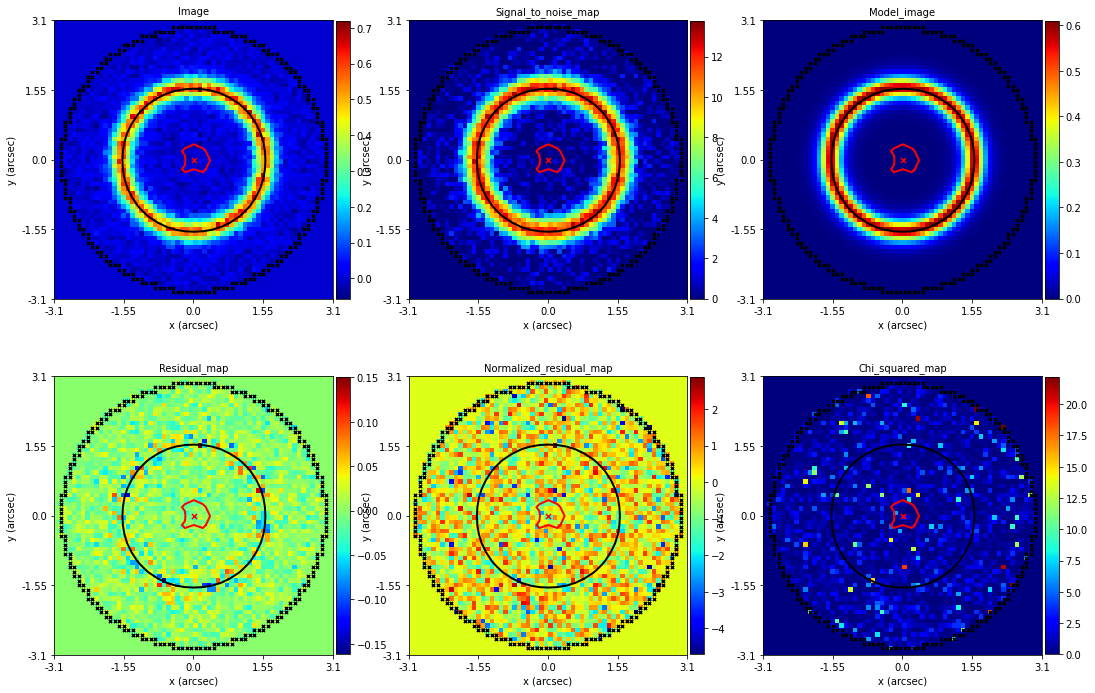

In [12]:
aplt.FitImaging.subplot_fit_imaging(fit=results.max_log_likelihood_fit)

The fit looks good and we've therefore found a model close to the one I used to simulate the image with (you can 
confirm this yourself if you want, by comparing the inferred parameters to those found in the script
'autolens_workspace/howtolens/simulators/lens_sis__source_exp.py').

And with that, we're done - you've successfully modeled your first strong lens with PyAutoLens